<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC1</p>
<p style="margin: 0; text-align:right;">2021-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 1: Redes neuronales artificiales

En esta práctica implementaremos redes neuronales artificiales para resolver problemas de:

   - Clasificación
   - Regresión   


**Importante: La entrega debe hacerse en formato notebook y en formato html donde se vea el código y los resultados y comentarios de cada ejercicio. Para exportar el notebook a html puede hacerse desde el menú File $\to$ Download as $\to$ HTML.**

## 0. Contexto y carga de librerías

El siguiente código carga los paquetes necesarios para la práctica y lee el fichero de datos que usaremos.

Los datos contienen información sobre coches de segunda mano, sus características y el precio de re-venta en euros. En un primer ejercicio diseñaremos un modelo que nos permita clasificar los coches en tres grupos según su gama de precio. En el segundo ejercicio diseñaremos un modelo de regresión para predecir el precio de re-venta.

In [97]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import timeit

import keras
from keras.models import Sequential, Model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import normalize


In [98]:
##To read directly from Drive in Google Colab use:
#from google.colab import drive
#drive.mount('/content/drive')


In [99]:
#df = pd.read_csv("/content/drive/MyDrive/vicente/dataset.csv")
df = pd.read_csv("dataset.csv")

In [100]:
df.head(5)

,months_old,km,fuel_type,horsepower,metcolor,automatic,size_engine,doors_num,weight,price
0,73,97494,Petrol,110,1,0,1600,5,1085,10950
1,48,89049,Petrol,97,1,0,1400,5,1060,13500
2,40,161000,Diesel,69,1,0,1900,3,1105,13950
3,37,38812,Petrol,97,0,0,1400,3,1025,13450
4,55,33230,Petrol,110,0,0,1600,3,1050,13500


## 1. Exploración (1 punto)



En primer lugar exploraremos el conjunto de datos. 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (1 punto):</strong> Explora los datos: 

<ul>
        
<li> Indica el tamaño del dataset y el número de variables categóricas y continuas del conjunto de datos</li> 
<li>   Grafica las distribuciones de las variables categóricas y de las continuas</li>
<li>    Genera una tabla de correlaciones de todas las variables usando la librería <code>seaborn</code>, mostrando en cada casilla el valor de la correlación</li>
<li>    Genera una tabla (usando la librería <code>seaborn</code>) que muestre únicamente las correlaciones entre el precio y el resto de variables, ordenada de mayor a menor según los valores de correlación</li>
<li>  Comenta los resultados de la exploración de datos</li>
</ul>

</div>



*   **Variables**



In [101]:
#Dataset size
df.describe()
df.shape

(1436, 10)

In [102]:
df.dtypes.value_counts()

int64     9
object    1
dtype: int64

In [103]:
#Number of categorical and continuous variables
num_categorical_variables = 1
num_continuous_variables = 9

*   **Distribuciones**





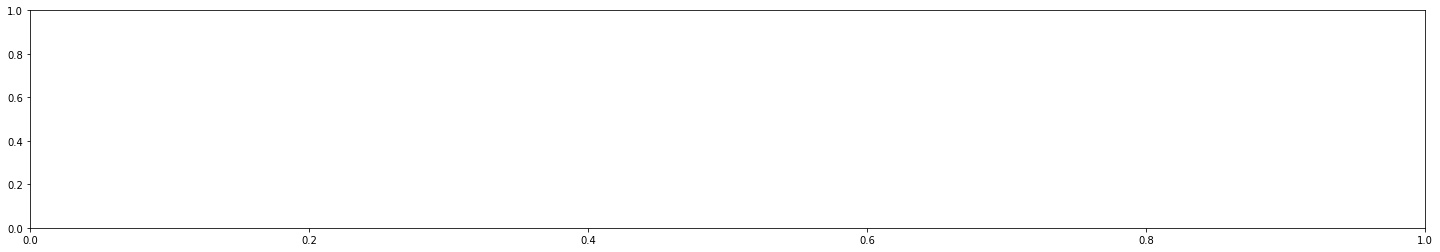

In [104]:
 #Distributions of categorical variables
 fig, ax = plt.subplots(nrows=1, ncols=num_categorical_variables, figsize=(25,4))



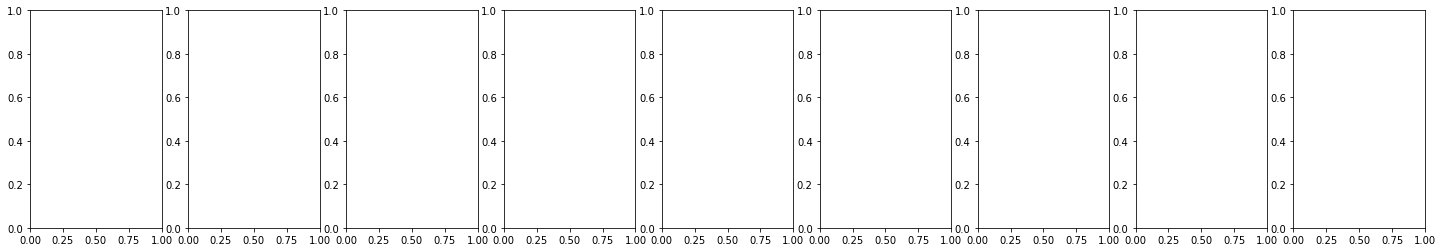

In [105]:
#Distributions continuous variables
fig, ax = plt.subplots(nrows=1, ncols=num_continuous_variables, figsize=(25,4))




*   **Correlaciones**




In [106]:
#All variables correlations
correlations=df.corr()
print(correlations)

             months_old        km  horsepower  metcolor  automatic  \
months_old     1.000000  0.502894   -0.157767 -0.106133   0.031003   
km             0.502894  1.000000   -0.333538 -0.080503  -0.081854   
horsepower    -0.157767 -0.333538    1.000000  0.058712   0.013144   
metcolor      -0.106133 -0.080503    0.058712  1.000000  -0.019335   
automatic      0.031003 -0.081854    0.013144 -0.019335   1.000000   
size_engine   -0.133181  0.300699    0.049362  0.036717  -0.069929   
doors_num     -0.148312 -0.036197    0.092424  0.085243  -0.027654   
weight        -0.463534 -0.030487    0.091274  0.056582   0.056271   
price         -0.873452 -0.569960    0.314990  0.108905   0.033081   

             size_engine  doors_num    weight     price  
months_old     -0.133181  -0.148312 -0.463534 -0.873452  
km              0.300699  -0.036197 -0.030487 -0.569960  
horsepower      0.049362   0.092424  0.091274  0.314990  
metcolor        0.036717   0.085243  0.056582  0.108905  
automatic

In [107]:
#Features correlating with Price
print(correlations["price"])

months_old    -0.873452
km            -0.569960
horsepower     0.314990
metcolor       0.108905
automatic      0.033081
size_engine    0.162985
doors_num      0.185326
weight         0.578452
price          1.000000
Name: price, dtype: float64




*   **Comentarios resultado exploración**



Contamos con un dataset de 10 dimensiones, 9 de ellas son continuas y 1 es categorica, sigue una distribución normal y las correlaciones entre ellas no son muy fuertes, excepto el precio y la edad del auto que es inversa 


## 2. Red neuronal artificial: Clasificación (4.5 puntos)


En este apartado entrenaremos un modelo que intente clasificar los coches según su gama de precio. Para ello crearemos una nueva variable como indicador de calidad del coche (gama baja, media o alta), siguiendo las siguientes condiciones:



*   _low-end_: precio menor que 11000 euros
*   _medium-end_: precio mayor o igual que 11000 euros y menor que 13000
*   _high-end_: precio mayor o igual que 13000



### Pre-procesado


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.75 puntos):</strong> Pre-procesa los datos: 

<ul>
        
<li>   Crea una nueva variable <code>quality</code> que incluya la gama del coche, con las condiciones indicadas</li>
<li>   Muestra el histograma de la nueva variable <code>quality</code></li>
<li>   Crea los vectores de variables dependientes (<i>features</i>) y de la variable independiente (<i>labels</i>)</li>
<li>   Normaliza debidamente los datos y binariza el vector de etiquetas (<i>labels</i>) </li>
<li>   Divide el conjunto de datos en 80% para entrenamiento y 20% para test, usando la función <code>train_test_split</code></li>
<li>   Muestra las dimensiones de los conjuntos de entrenamiento y test</li>
</ul>
</div>

In [108]:
#Create new variable: quality
df["quality"]=df.apply(lambda x: "low-end" if int(x["price"]) < 11000 else "medium-end" if int(x["price"]) < 13000 else "high-end", axis=1)

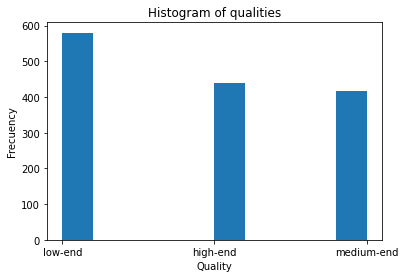

In [109]:
#Histogram car quality
plt.hist(x=df["quality"])
plt.title('Histogram of qualities')
plt.xlabel('Quality')
plt.ylabel('Frecuency')

plt.show() 

In [110]:
#Create features and labels vectors

labels = np.array(df[["quality"]])
features = np.array(df[["months_old","km","horsepower","metcolor","automatic","size_engine","doors_num","weight","price"]])


In [111]:
#Normalize the corresponding data
features = normalize(features)
features

array([[7.43940484e-04, 9.93557994e-01, 1.12100621e-03, ...,
        5.09548277e-05, 1.10571976e-02, 1.11591073e-01],
       [5.32837901e-04, 9.88514214e-01, 1.07677659e-03, ...,
        5.55039481e-05, 1.17668370e-02, 1.49860660e-01],
       [2.47496891e-04, 9.96174987e-01, 4.26932137e-04, ...,
        1.85622668e-05, 6.83710162e-03, 8.63145408e-02],
       ...,
       [9.32136539e-04, 9.93911769e-01, 1.04108756e-03, ...,
        3.63170080e-05, 1.22872544e-02, 1.08345741e-01],
       [9.64122195e-04, 9.31655380e-01, 2.65133604e-03, ...,
        1.20515274e-04, 2.60312993e-02, 3.60340671e-01],
       [1.29786670e-03, 9.63897002e-01, 2.41975148e-03, ...,
        1.09988703e-04, 2.35375825e-02, 2.62873001e-01]])

In [112]:
print(labels)

[['low-end']
 ['high-end']
 ['high-end']
 ...
 ['low-end']
 ['high-end']
 ['medium-end']]


In [113]:
#Binarize the labels

#labels = OneHotEncoder(handle_unknown='ignore').fit_transform(labels).toarray()
labels = OneHotEncoder(handle_unknown='ignore').fit_transform(labels)
print(labels)

  (0, 1)	1.0
  (1, 0)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (4, 0)	1.0
  (5, 0)	1.0
  (6, 2)	1.0
  (7, 2)	1.0
  (8, 2)	1.0
  (9, 1)	1.0
  (10, 1)	1.0
  (11, 0)	1.0
  (12, 1)	1.0
  (13, 0)	1.0
  (14, 2)	1.0
  (15, 0)	1.0
  (16, 1)	1.0
  (17, 0)	1.0
  (18, 2)	1.0
  (19, 0)	1.0
  (20, 0)	1.0
  (21, 1)	1.0
  (22, 1)	1.0
  (23, 0)	1.0
  (24, 1)	1.0
  :	:
  (1411, 0)	1.0
  (1412, 1)	1.0
  (1413, 1)	1.0
  (1414, 0)	1.0
  (1415, 0)	1.0
  (1416, 0)	1.0
  (1417, 0)	1.0
  (1418, 2)	1.0
  (1419, 0)	1.0
  (1420, 2)	1.0
  (1421, 0)	1.0
  (1422, 0)	1.0
  (1423, 0)	1.0
  (1424, 1)	1.0
  (1425, 1)	1.0
  (1426, 2)	1.0
  (1427, 2)	1.0
  (1428, 1)	1.0
  (1429, 1)	1.0
  (1430, 0)	1.0
  (1431, 2)	1.0
  (1432, 1)	1.0
  (1433, 1)	1.0
  (1434, 0)	1.0
  (1435, 2)	1.0


In [116]:
#Train-test split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)


In [117]:
#Shapes
print('Dimensiones de conjunto features de entrenamiento: ' , X_train.shape)
print('Dimensiones de conjunto features de test: ', X_test.shape)
print('Dimensiones de conjunto labels de entrenamiento: ', y_train.shape)
print('Dimensiones de conjunto labels de test: ', y_test.shape)

Dimensiones de conjunto features de entrenamiento:  (1148, 9)
Dimensiones de conjunto features de test:  (288, 9)
Dimensiones de conjunto labels de entrenamiento:  (1148, 3)
Dimensiones de conjunto labels de test:  (288, 3)


### Modelo base


Empezaremos diseñando un modelo base con 4 capas ocultas.
 
Nota: Para el ajuste del modelo usaremos los datos de test como conjunto de validación.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (1.25 puntos):</strong> Implementa el modelo de red neuronal artificial:
<ul>
<li>   Diseña la arquitectura para el modelo de clasificación con la función de activación adecuada para la capa de salida y con las siguientes características:</li>
   <ul>
   <li> 4 capas ocultas con 64, 32, 10, 8 neuronas sucesivamente</li>
   <li> Función de activación de las capas intermedias: ReLU</li>
   </ul>

<li>   Compila el modelo con la función de pérdida más adecuada, el optimizador Adam, una velocidad de aprendizaje de 0.1, y la métrica Accuracy.</li>

<li>   Ajusta el modelo con 20 épocas y un tamaño del batch de 64</li>

<li>   Muestra las gráficas de accuracy y loss. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación</li>
</ul>
</div>

In [134]:
#Create ANN model
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
 



In [137]:
#Compile
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [139]:
#Fit
model.fit(X_train, y_train, epochs=20)

Epoch 1/20


ValueError: in user code:

    File "/home/angel/notebook/jupyterenv/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/home/angel/notebook/jupyterenv/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/angel/notebook/jupyterenv/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/home/angel/notebook/jupyterenv/lib/python3.8/site-packages/keras/engine/training.py", line 861, in train_step
        self._validate_target_and_loss(y, loss)
    File "/home/angel/notebook/jupyterenv/lib/python3.8/site-packages/keras/engine/training.py", line 818, in _validate_target_and_loss
        raise ValueError(

    ValueError: Target data is missing. Your model was compiled with loss=binary_crossentropy, and therefore expects target data to be provided in `fit()`.


In [ ]:
#Plots 


### Influencia velocidad aprendizaje y optimizador

Una vez tenemos el modelo base, analizaremos la influencia que pueden tener la velocidad de aprendizaje y el tipo de optimizador en la mejora del rendimiento.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (1.5 puntos):</strong> Implementa una función para entrenar la arquitectura del ejercicio anterior para 4 optimizadores diferentes: Adam, SGD, Adadelta, Adagrad, y 4 velocidades de aprendizaje: 0.001, 0.01, 0.05, 0.1. 
Entrena los modelos, y representa dos gráficas:
 <ul>
     <li> Tiempo de entrenamiento vs Velocidad de aprendizaje</li>
     <li>  <i>Accuracy</i> vs Velocidad de aprendizaje</li>
</ul>   
    
Cada gráfica debe incluir la evolución obtenida por los cuatro optimizadores para poderlos comparar mejor.
    
-----------------------------------------------------------------------------------------------------------
<b>Importante</b>: para la entrega de la PEC, fijar el parámetro <code>verbose = 0</code> en el entrenamiento de los modelos. La solución únicamente debe mostrar las gráficas resultantes.
</div>

In [ ]:
#Function to compute several models changing Optimizers and learning rate


In [ ]:
#Compute models


In [ ]:
#Plots


### Elección del mejor modelo

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (1 punto):</strong> Identifica el valor de la velocidad de aprendizaje y del optimizador que mejor rendimiento dan al modelo, según los resultados del ejercicio anterior:
<ul>
    
<li>   Justifica la elección</li>
<li>   Compila y entrena el modelo elegido</li>
<li>   Muestra las correspondientes gráficas de <i>Accuracy</i> y <i>Loss</i> de los conjuntos de entrenamiento y validación, e indica el <i>Accuracy</i> del modelo </li>
<li>   Muestra la matriz de confusión multi-clase con las etiquetas originales de <code>quality</code> (<i>low-end</i>, <i>medium-end</i>, <i>high-end</i>)</li>
<li>   Muestra la precisión, recall y F1-score resultantes para cada etiqueta</li>
<li>   Comenta los resultados obtenidos</li>
</ul>
</div>

In [ ]:
#Best model justification


In [ ]:
#Create, compile and fit ANN BEST model


In [ ]:
#Plots


In [ ]:
#Confusion matrix


In [ ]:
#Accuracy


In [ ]:
#Precision, Recall and F1-score for each label


In [ ]:
#Comment results


## 3. Red neuronal artificial: Regresión (4.5 puntos)

En este apartado resolveremos un problema de regresión intentando predecir el precio de re-venta según las características de los coches. Partiremos del conjunto de datos original.

### Pre-procesado




<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.5 puntos):</strong> Pre-procesa los datos: 
<ul>
<li>   Crea los vectores de variables dependientes (<i>features</i>) y de la variable independiente (<i>target</i>)</li>
<li>   Normaliza debidamente los datos</li>
<li>   Divide el conjunto de datos en 70% para entrenamiento y 30% para test, usando la función <code>train_test_split</code></li>
<li>   Muestra las dimensiones de los conjuntos de entrenamiento y test</li>
</ul>
</div>

In [ ]:
#Create features and target vectors
features = None
target = None

In [ ]:
#Normalizing the data


In [ ]:
#Split train-test


In [ ]:
#Dimensions


### Modelo base

En primer lugar diseñaremos un modelo base con tres capas ocultas.

Nota: Para el ajuste del modelo usaremos los datos de test como conjunto de validación.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (1 punto):</strong> Implementa el modelo de red neuronal artificial:
<ul>
<li>Diseña la arquitectura para el modelo de regresión con las siguientes características:</li>
    <ul>
   <li>1 primera capa oculta completamente conectada de 128 neuronas y activación ReLU</li>
   <li>2 capas ocultas de 32 y 16 neuronas y activación tangencial</li>
   <li>Todas las capas deben tener <code>kernel_initizalizer</code> en modo 'normal'</li>
   </ul>
<li>Compila el modelo con la función de pérdida más adecuada y el optimizador Adam</li>

<li>Ajusta el modelo con 50 épocas y un tamaño del batch de 32</li>

<li>Muestra la gráfica de pérdida. En la gráfica debe visualizarse la curva de entrenamiento y la de validación</li>
</ul>
</div>

In [ ]:
#Create ANN model


In [ ]:
#Compiling the model


In [ ]:
#Fit model


In [ ]:
#Plots


### Búsqueda hiperparámetros

Una vez tenemos el modelo base nos interesa buscar la configuración de hiperparámetros que nos proporcione una mejor predicción del precio de re-venta de los coches. En este apartado haremos una búsqueda de hiperparámetros, recorriendo varios valores de número de capas, número de neuronas, tamaño del batch y épocas.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (1.75 puntos):</strong> Implementa una función que evalúe distintos modelos combinando las siguientes características:
<ul>    
   <li>Tres arquitecturas diferentes con las siguientes configuraciones de número de capas ocultas (completamente conectadas) y número de neuronas en cada capa:</li>
        <ul>
        <li>[128, 64, 16]</li>
        <li>[16, 4]</li>
        <li>[4, 4]</li>
        </ul> 
   <li>Tamaño del batch de 16 y 32</li>
   <li>Épocas de 20, 50 y 100</li>
</ul>   
    
    
Como en el ejercicio anterior, la primera capa oculta tendrá siempre activación ReLU y las demás activación tangencial. El inicializador de kernel estará en modo 'normal' y usaremos el optimizador Adam.

    
La función deberá proporcionar una tabla con los siguientes campos: arquitectura de la red seleccionada, épocas, tamaño del batch, tiempo de entrenamiento, y raíz del error cuadrático medio (RMSE) del modelo 

-----------------------------------------------------------------------------------------------------------
<b>Importante</b>: para la entrega de la PEC, fijar el parámetro <code>verbose = 0</code> en el entrenamiento de los modelos. La solución únicamente debe mostrar la tabla resultante.
</div>

In [ ]:
#Hiperparameter search function


In [ ]:
#Compute search


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.25 puntos):</strong> Representa en un gráfico el RMSE vs la configuración de los modelos 

</div>

In [ ]:
#Plot


### Elección mejor modelo y predicción

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (1 punto):</strong> Identifica la configuración que proporciona mejores resultados:
<ul> 
<li>Justifica la elección del modelo</li>
<li>Compila y entrena el modelo elegido. Nota: para la entrega, presentar con verbose=0</li>
<li>Muestra la correspondiente gráfica de pérdida de los conjuntos de entrenamiento y validación</li>
<li>Calcula las predicciones del precio y muestra en una tabla el Precio original (<code>price</code>) y el Precio predicho (<code>predicted_price</code>) para las 10 primeras filas del conjunto de test</li>
<li>Comenta los resultados obtenidos</li>
</ul> 
</div>

In [ ]:
#Best configuration justification


In [ ]:
#Create, compile and fit ANN best model


In [ ]:
#Plot


In [ ]:
#Generate Predictions on testing data


In [ ]:
#Comment results
